In [40]:
import matplotlib.pyplot as plt
import numpy as np
import json

TRAFFIC_LEVELS  = [0, 0.5, 1]
BATTERY_CHARGE = 2.85
TIME_EXPERIMENT = 60*60*12


In [41]:
# Load data:
#   - look for last snapshot 
#   - look for last hr

netLatency          = {}
netPathStability    = {}
netReliability      = {}
accumulated_charge  = {}
PDRByFrequency      = {}

for t in TRAFFIC_LEVELS:
    netLatency[t]         = [0 for x in range(4)]
    netPathStability[t]   = [0 for x in range(4)]
    netReliability[t]     = [0 for x in range(4)]
    accumulated_charge[t] = [0 for x in range(4)]
    PDRByFrequency[t]     = [0 for x in range(4)]
    
    for n in range(0,4):
        if n==0 and t!=0:
            continue
        
        PDRByFrequency[t][n] = [{} for x in range(15)]
        for i in range(0,15):
            PDRByFrequency[t][n][i] = {}
            PDRByFrequency[t][n][i]['txUnicastAttempts'] = 0
            PDRByFrequency[t][n][i]['txUnicastFailures'] = 0
        
        with open('{0}_wifiAP_{1}_traffic.log'.format(n,t), 'r') as f:
            line          = f.readline()
            charge        = {}
            while line:
                line      = json.loads(line)
                
                if line['name'] == 'snapshot':
                    netLatency[t][n]          = line['snapshot']['getNetworkInfo']['netLatency']
                    netPathStability[t][n]    = line['snapshot']['getNetworkInfo']['netPathStability']
                    netReliability[t][n]      = line['snapshot']['getNetworkInfo']['netReliability']

                if 'hr' in line.keys():
                    if 'Device' in line['hr'].keys():
                        if not(line['mac'] in charge):
                            charge[line['mac']]     = []
                        charge[line['mac']] += [line['hr']['Device']['charge'],]
                    if 'Extended' in line['hr'].keys():
                        rssi = line['hr']['Extended']['RSSI']
                        for i in range(len(rssi)):
                            PDRByFrequency[t][n][i]['txUnicastAttempts'] += rssi[i]['txUnicastAttempts']
                            PDRByFrequency[t][n][i]['txUnicastFailures'] += rssi[i]['txUnicastFailures']
                                                
                line  = f.readline()
            
            # PDR calculation for each case
            for i in range(0,15):
                PDRByFrequency[t][n][i]['PDR'] = 1-float(PDRByFrequency[t][n][i]['txUnicastFailures'])/float(PDRByFrequency[t][n][i]['txUnicastAttempts'])
                
            
            # take the last charge data received from all motes
            for c in charge:
                charge[c] = charge[c][-1]
            accumulated_charge[t][n] = charge

In [42]:
from matplotlib.legend_handler import HandlerLine2D

def plot_statistics(data, title, name, ymini=-1, ymaxi=-1, anotate=1):
    
    colors      = ['green', 'orange', 'red', 'black' ]
    linestyle   = [':','-','--','-.']
    markers     = ['o', 's', '^', '*']
    
    for n in range(3,0,-1):
        data_to_plot = []
        for l in data:
            data_to_plot += [data[l][n],]
            
        plt.plot(TRAFFIC_LEVELS, data_to_plot, 
                 label      = '{0} WiFi networks'.format(n),
                 marker     = markers[n],
                 linestyle  = linestyle[n],
                 color      = colors[n])
 

    plt.plot(0,data[0][0], marker = 'o', color='green', markersize=12)
    
    plt.xlabel('Interference Level')
    plt.ylabel(name)
    
    if ymini != -1 :
        plt.ylim(ymin=ymini, ymax=ymaxi)
    
    plt.legend()
    
    plt.annotate('No WiFi', 
             xy     =(0,data[0][0]),  
             xytext =(-0.03,data[0][0]*anotate),
             color  = 'green')
    
    plt.savefig('{0}.png'.format(title), dpi=300)
    plt.show()
    

In [43]:
max_charge     = {}
life_time      = {} # for each mote
time_to_live   = {} # network time
charge         = {}
plot_charge    = []
labels_boxplot = []     

for t in TRAFFIC_LEVELS:
    max_charge[t]     = [0 for x in range(4)]
    time_to_live[t]   = [0 for x in range(4)]
    charge[t]         = [0 for x in range(4)]
    life_time[t]      = [0 for x in range(4)]
    
    for n in range(0,4):
        if n==0 and t!=0:
            continue
        max_charge[t][n] = 0
        charge[t][n]     = []
        try:
            for c in accumulated_charge[t][n]:
                charge[t][n] += [accumulated_charge[t][n][c],]
                if accumulated_charge[t][n][c] >  max_charge[t][n]:
                    max_charge[t][n] = accumulated_charge[t][n][c]
        except:
            pass
        
        
        life_time[t][n] = []
        for a in charge[t][n]:
            if a != 0 :
                life_time[t][n] += [(BATTERY_CHARGE*TIME_EXPERIMENT)/(a*24*365)*1000,]
        
        if max_charge[t][n] != 0:
            try:
                time_to_live[t][n] = (BATTERY_CHARGE*TIME_EXPERIMENT)/(max_charge[t][n]*24*365)*1000
            except:
                pass

# reorganize data to plot it 
            
plotbox_lifetime = []

for n in range(0,4):
    for t in TRAFFIC_LEVELS:
        if n==0 and t!=0:
            continue
        plotbox_lifetime += [life_time[t][n],]
        labels_boxplot += ['{0}Tr_{1}Wi'.format(t,n),]

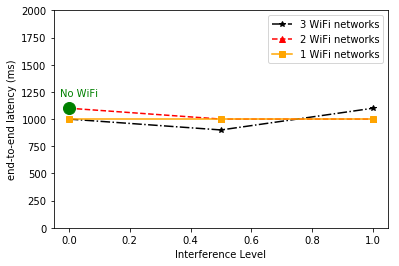

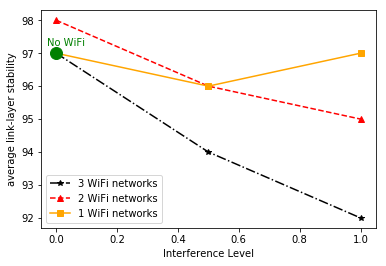

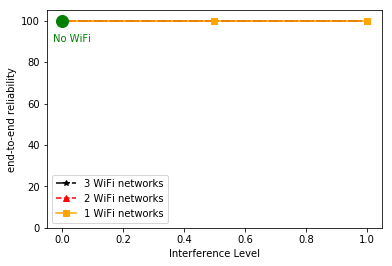

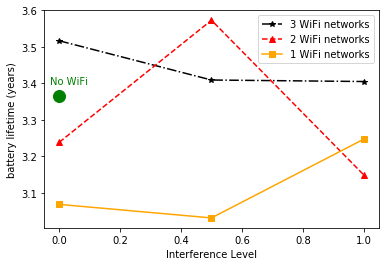

In [44]:
plot_statistics(netLatency, 'Average_Network_Latency', 'end-to-end latency (ms)', 0, 2000, 1.1)
plot_statistics(netPathStability, 'Network_Average_PDR', 'average link-layer stability',-1, -1, 1.0025)
plot_statistics(netReliability, 'Network_E2E_Reliability', 'end-to-end reliability', 0, 105, 0.9)
plot_statistics(time_to_live, 'Network_Lifetime', 'battery lifetime (years)', -1, -1, 1.01)

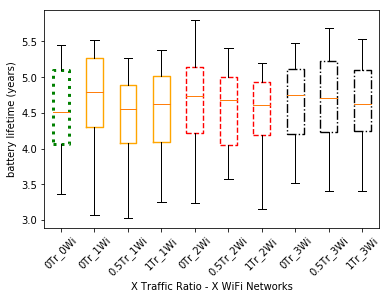

In [45]:
bp = plt.boxplot(plotbox_lifetime, labels=labels_boxplot)
colors = ['green', 'orange', 'orange', 'orange', 'red', 'red', 'red', 'black', 'black', 'black',]
lines  = [':','-', '-', '-', '--', '--', '--','-.','-.','-.']
for (idx, box) in enumerate(bp['boxes']):
    if idx == 0 :
        box.set( color=colors[idx], linewidth=3,linestyle=lines[idx])
    else:
        box.set( color=colors[idx], linewidth=1.4,linestyle=lines[idx])
plt.xticks(rotation=45)
plt.xlabel('X Traffic Ratio - X WiFi Networks')
plt.ylabel('battery lifetime (years)')
plt.savefig('Battery_lifetime_distribution_of_all_motes.png',pad_inches=0.1, bbox_inches='tight', dpi = 200)
plt.show()

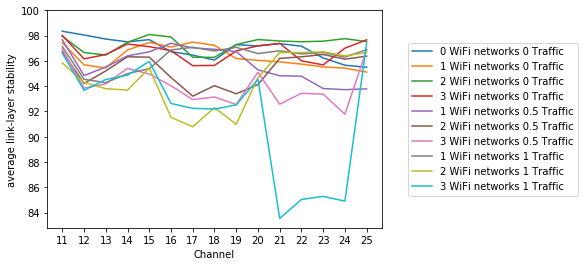

In [77]:
from matplotlib import pylab
for t in TRAFFIC_LEVELS:
    for n in range(0,4):
        if n==0 and t!=0:
            continue
        PDR_list = []
        for i in range(len(PDRByFrequency[t][n])):
            PDR_list += [PDRByFrequency[t][n][i]['PDR']*100,]
        plt.plot([x for x in range(11,26)], PDR_list, 
                 label      = '{0} WiFi networks {1} Traffic'.format(n,t),)
        
plt.legend()
plt.xlabel('Channel')
plt.ylabel('average link-layer stability')
pylab.legend(loc=5, bbox_to_anchor=(1.6, 0.5))
plt.ylim(ymax=100)
plt.xticks([x for x in range(11,26)])
plt.savefig('pdr_per_channel.png',pad_inches=0.1, bbox_inches='tight', dpi = 300)
plt.show()